In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch as torch

from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import ConstantRealFcn
from janelia_core.ml.torch_distributions import CondGammaDistribution


## Parameters go here

In [3]:
n_smps = 10000

# Setup conditional Gamma distributions

In [4]:
conc_f = ConstantRealFcn(init_vl=torch.tensor([1.0, 20.0, 3.0, 4.0]))
rate_f = ConstantRealFcn(init_vl=torch.tensor([1.0, 2.0, 1.0, 2.0]))
dist = CondGammaDistribution(conc_f=conc_f, rate_f=rate_f)

## Generate samples

In [5]:
with torch.no_grad():
    x = torch.rand(n_smps, 2)
    smps = dist.sample(x)

## Visualize distributions of samples

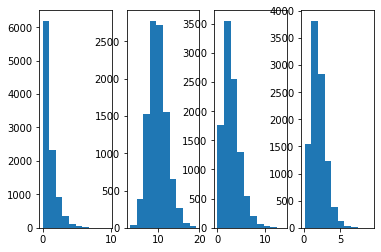

In [6]:
plot_smps = smps.numpy()
n_dists = plot_smps.shape[1]
for d_i in range(n_dists):
    plt.subplot(1,n_dists,d_i + 1)
    plt.hist(plot_smps[:,d_i])

## Fit a new distribution to the sample data 

In [7]:
conf_f_hat = ConstantBoundedFcn(lower_bound=.1*np.ones(4), upper_bound=5.0*np.ones(4), 
                                init_value=1.0*np.ones(4))
rate_f_hat = ConstantBoundedFcn(lower_bound=.1*np.ones(4), upper_bound=5.0*np.ones(4), 
                                init_value=1.0*np.ones(4))

fit_dist = CondGammaDistribution(conc_f=conf_f_hat, rate_f=rate_f_hat)

In [9]:
optimizer = torch.optim.Adam(params=fit_dist.parameters(), lr=1)
for it in range(2000):
    optimizer.zero_grad()
    nll = -1*torch.sum(fit_dist.log_prob(x=x, y=smps))
    nll.backward()
    optimizer.step()
    
    if it % 100 == 0:
        print('It: ' + str(it) + ', nll: '+ str(nll.detach().numpy()))

It: 0, nll: 67129.27
It: 100, nll: 72695.5
It: 200, nll: 71863.58
It: 300, nll: 71863.35
It: 400, nll: 71863.22
It: 500, nll: 71863.02
It: 600, nll: 71862.66
It: 700, nll: 71861.89
It: 800, nll: 71859.336
It: 900, nll: 71444.164
It: 1000, nll: 67262.19
It: 1100, nll: 67262.15
It: 1200, nll: 67262.13
It: 1300, nll: 67434.195
It: 1400, nll: 67262.125
It: 1500, nll: 67405.4
It: 1600, nll: 67422.35
It: 1700, nll: 67337.66
It: 1800, nll: 67407.57
It: 1900, nll: 67382.414


## Look at distributions of samples from fit functions

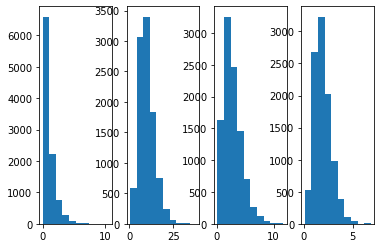

In [10]:
with torch.no_grad():
    fit_smps = fit_dist.sample(x)
    
plot_fit_smps = fit_smps.numpy()
n_dists = plot_fit_smps.shape[1]
for d_i in range(n_dists):
    plt.subplot(1,n_dists,d_i + 1)
    plt.hist(plot_fit_smps[:,d_i])

## Fit a new distribution to the true one by minimize KL divergences

In [11]:
conf_f_kl = ConstantBoundedFcn(lower_bound=.1*np.ones(4), upper_bound=5.0*np.ones(4), 
                                init_value=1.0*np.ones(4))
rate_f_kl = ConstantBoundedFcn(lower_bound=.1*np.ones(4), upper_bound=5.0*np.ones(4), 
                                init_value=1.0*np.ones(4))

dist_kl = CondGammaDistribution(conc_f=conf_f_kl, rate_f=rate_f_kl)

In [12]:
optimizer = torch.optim.Adam(params=dist_kl.parameters(), lr=.01)
for it in range(2000):
    optimizer.zero_grad()
    kl = torch.sum(dist.kl(d_2=dist_kl, x=x))
    kl.backward()
    optimizer.step()
    
    if it % 100 == 0:
        print('It: ' + str(it) + ', kl: '+ str(kl.detach().numpy()))

It: 0, kl: 96154.016
It: 100, kl: 8929.938
It: 200, kl: 5497.2715
It: 300, kl: 4860.984
It: 400, kl: 4493.8667
It: 500, kl: 4233.2285
It: 600, kl: 4037.021
It: 700, kl: 3888.166
It: 800, kl: 3775.1167
It: 900, kl: 3688.676
It: 1000, kl: 3621.8284
It: 1100, kl: 3569.4866
It: 1200, kl: 3527.7542
It: 1300, kl: 3494.1306
It: 1400, kl: 3466.5857
It: 1500, kl: 3443.816
It: 1600, kl: 3424.7026
It: 1700, kl: 3408.5823
It: 1800, kl: 3394.7988
It: 1900, kl: 3382.951


## Look at distributions of samples from fit functions

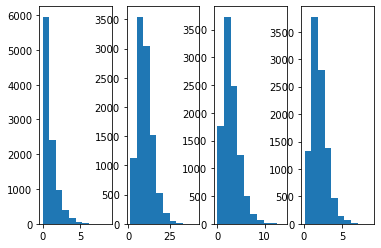

In [13]:
with torch.no_grad():
    fit_smps = dist_kl.sample(x)
    
plot_fit_smps = fit_smps.numpy()
n_dists = plot_fit_smps.shape[1]
for d_i in range(n_dists):
    plt.subplot(1,n_dists,d_i + 1)
    plt.hist(plot_fit_smps[:,d_i])